In [1]:
import glob
import datetime

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from matplotlib import animation, rc
import matplotlib.colors as colors
from IPython.display import HTML
import seaborn as sns
from netCDF4 import Dataset
from sklearn.neighbors import KDTree, BallTree

The current assumption is that there is a need to discriminate between surficial and sub-surface fires, as the coefficients need to be applied appropriately.  Previous attempts to perform this discrimination have focused on a spectral ratio approach that attempted to determine whether a fire was actively flaming (indicating a surface fire) or not (assumed to indicate a subsurface peat fire).  It was unsuccesful and no such discrimination could be effectively achieved, this is likely due to mixed fire phases occupying a single pixel, i.e. whilst near-surface and deep peat fires are likely dominated by smouldering, surface fires also likely have a significant proportion of thier composition associated with smouldering and so it is difficult to effectively discriminate between them.  

After further analysis the need for such a disrimination has been brought into question.  If we make the assumption that all fires begin on the surface, then any new fires much be associated with surface burning.  One issue with this though is that peat fires can spread underground, meaning that a thermal anomaly that appears in a certain location may come from a subsurface peat fire.  This would only be an issue if this subsurface fire move between pixels, and the question then is how likely are subsurface peat fire to move between pixels?  The probability of this happening is low (can model this - for a 2km pixel assuming a 1m/day spread speed and a 90 day burn period you have a 9% chance of a fire with a pixel crossing occuring), as peat fire spread speeds are very low compared to the geostationary imager pixel size (< 10 cm/h vs. 2km).

So therefore, we can justify that nearly all fires start as surface fires.

Issue of repeat burns - when do we consider a repeat burn of a pixel a new fire?  Does this even matter?  How many fires burn over the same pixel?  How long do peat fires typically last?  We can assess this and then put in a threshold, if less than a certain number of days then assume it is not a new fire.    

Refs:

https://www.jstage.jst.go.jp/article/tropics/14/1/14_1_1/_pdf


So what to do next:
• Fire lifetime distributions, peat and non-peat

In [9]:
# read in the himawari lat and lon data
#geo_file = '/Users/danielfisher/Projects/kcl-fire-aot/data/Asia/processed/himawari/Himawari_lat_lon.img'
geo_file = '/Users/dnf/Projects/kcl-fire-aot/data/Asia/processed/himawari/Himawari_lat_lon.img'
geostationary_lats, geostationary_lons = geo_read(geo_file)

In [11]:
# load in the peat maps
#path_to_peat_maps = '/Users/danielfisher/Projects/kcl-fire-aot/data/Asia/external/peat_maps/'
path_to_peat_maps = '/Users/dnf/Projects/kcl-fire-aot/data/Asia/external/peat_maps/'
df_list = []
peat_maps_paths = glob.glob(path_to_peat_maps + '*/*.nc')
for peat_maps_path in peat_maps_paths:
    peat_map_key = peat_maps_path.split("/")[-1].split(".")[0]
    d = read_nc(peat_maps_path)
    df_list.append(pd.DataFrame.from_dict(d))
peat_df = pd.concat(df_list)

In [12]:
# path = '/Users/danielfisher/Projects/kcl-fire-aot/data/Asia/processed/himawari/updated/frp_df.p'
path = '/Users/dnf/Projects/kcl-fire-aot/data/Asia/processed/himawari/updated/frp_df.p'
fires_df = pd.read_pickle(path)

In [13]:
# spatial subset to ROI
mask = ((fires_df.LATITUDE > -7) & (fires_df.LATITUDE < 4) & 
        (fires_df.LONGITUDE > 94) & (fires_df.LONGITUDE < 119))
fires_df = fires_df[mask]

In [14]:
fires_df = fires_df.sort_values('obs_time', ascending=True)
fires_df.reset_index(inplace=True)
fires_df.drop('index', axis=1, inplace=True)

In [15]:
id_array = np.zeros([5500, 5500])
time_array = np.zeros([5500, 5500])

fire_ids = fire_ids = np.zeros(fires_df.shape[0]) 
current_max_fire_id = 1

for i, row in fires_df.iterrows():
    
    l = int(row.ABS_line)
    s = int(row.ABS_samp)
    
    nearby_ids = (id_array[l-1:l+2, s-1:s+2]).flatten()  # get the 3x3 array centred on the current sample
    
    # convert row obs time to number
    row_obs_time = (row.obs_time - np.datetime64('1970-01-01T00:00:00Z')) / np.timedelta64(1, 's')
    
    # if no previous fires in the 3x3 region
    if np.max(nearby_ids) == 0:
        id_array[l,s] = current_max_fire_id  # set the id in the array
        time_array[l,s] = row_obs_time  # TODO convert time to number
        fire_ids[i] = current_max_fire_id  # assign the id
        current_max_fire_id += 1  # update the id
        
    # if there are previous fires in the 3x3 region then find the 
    # temporally nearest, and use that to update the arrays
    else:
        nearby_times = (time_array[l-1:l+2, s-1:s+2]).flatten()
        nearest_time_index = np.argmin(np.abs(nearby_times - row_obs_time))  # TODO convert time to number
        nearest_id = nearby_ids[nearest_time_index]  # get the temporally closest id
        nearest_time = nearby_times[nearest_time_index]

        # update
        id_array[l,s] = nearest_id
        time_array[l,s] = nearest_time
        fire_ids[i] = nearest_id

/Users/dnf/anaconda2/envs/kcl-fire-aot/lib/python2.7/site-packages/ipykernel_launcher.py:15: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
  from ipykernel import kernelapp as app


In [16]:
# append fire ids to df and drop single detections
fires_df['fire_id'] = fire_ids
fires_df['sample_count'] = 1 
fires_df_samples = fires_df.groupby('fire_id', as_index=False).agg({'sample_count': np.sum})
fires_df.drop('sample_count', axis=1, inplace=True)

# lets keep only more persistent fires
fires_df_samples = fires_df_samples[fires_df_samples.sample_count > 48]

# now merge 
subset_fires_df = pd.merge(fires_df, fires_df_samples, on='fire_id')

In [17]:
# now add the peat information to the subset fires
subset_fires_df = assign_peat(peat_df, subset_fires_df)

In [18]:
# compute the number of days since the first burn

df_with_burn_times = subset_fires_df.copy()
df_with_burn_times['min_time'] = df_with_burn_times.obs_time.copy()
df_with_burn_times = df_with_burn_times.groupby(['ABS_line', 'ABS_samp'],as_index=False).agg({'min_time': np.min})

# standardise the start time
df_with_burn_times.min_time = df_with_burn_times.min_time.dt.normalize() 

# merge first time burn onto sub df
df_with_burn_times = pd.merge(subset_fires_df, df_with_burn_times, on=['ABS_line', 'ABS_samp'])

# get days since first burn as a float
subset_fires_df['days_since_first_burn'] = (df_with_burn_times.obs_time.dt.normalize() - 
                                            df_with_burn_times.min_time) / np.timedelta64(24, 'h')

# add in solar time
subset_fires_df['local_solar_time'] = subset_fires_df.obs_time + pd.to_timedelta((subset_fires_df.LONGITUDE + 180 ) / 360 * 12, 'h')

# get hour since local midnight
subset_fires_df['hours_since_local_midnight'] = ((subset_fires_df.local_solar_time - 
                                                  subset_fires_df.local_solar_time.dt.normalize()) / np.timedelta64(1, 'h')).astype(int)


In [19]:
subset_fires_df.head()

,FIRE_CONFIDENCE,ABS_line,ABS_samp,BT_MIR,BT_TIR,FRP_0,LATITUDE,LONGITUDE,obs_time,obs_date,fire_id,sample_count,is_peat,days_since_first_burn,local_solar_time,hours_since_local_midnight
0,0.614031,2552.0,651.0,314.550,293.622,55.8281,3.77182,96.6114,2015-07-02 03:50:00,2015-07-02,1.0,73,False,0.0,2015-07-02 13:03:13.368000,13
1,0.640497,2552.0,650.0,312.329,292.752,41.5363,3.77209,96.5812,2015-07-02 03:50:00,2015-07-02,1.0,73,True,0.0,2015-07-02 13:03:09.742800,13
2,0.628033,2552.0,650.0,313.228,293.024,46.6538,3.77209,96.5812,2015-07-02 04:00:00,2015-07-02,1.0,73,True,0.0,2015-07-02 13:13:09.742800,13
3,0.704558,2552.0,651.0,315.995,293.649,65.0966,3.77182,96.6114,2015-07-02 04:00:00,2015-07-02,1.0,73,False,0.0,2015-07-02 13:13:13.368000,13
4,0.699888,2552.0,651.0,313.854,293.892,50.4289,3.77182,96.6114,2015-07-02 04:10:00,2015-07-02,1.0,73,False,0.0,2015-07-02 13:23:13.368000,13


In [21]:
subset_fires_df_test = subset_fires_df.copy()
subset_fires_df_test = subset_fires_df_test.groupby(['fire_id', 'is_peat'], as_index=False).agg({'days_since_first_burn': np.max})

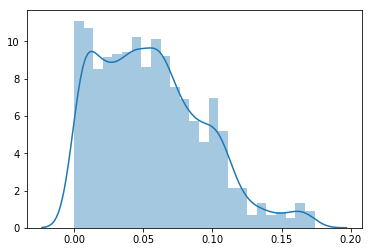

In [36]:
# lets assume a 1m per day progression so we can just use the day value 
max_permitted_distance_to_pixel_edge = 2 - subset_fires_df_test.days_since_first_burn.values / 1000  # in km

# now lets compute probability of fire reaching the pixel edge.  To understand this imagine that
# the fire can start anywhere in the pixel, but only if it starts within a certain away from the
# pixel edge will it progress into an adjacent pixel.  All possible start locations are defined
# by the pixel size, those locations near the edge that might progress in to an adjancent pixel
# are those locations within some distance of the pixel border.  This is based on the speed of
# of the fire spread (here assumed to be 1 m/day).  
prob_of_reaching_pixel_edge = 1 - (max_permitted_distance_to_pixel_edge**2 / 2**2)

# then can plot the distribution of that happening
sns.distplot(prob_of_reaching_pixel_edge)
plt.show()

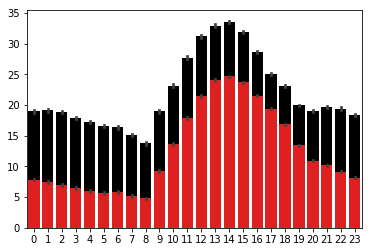

In [211]:
mask = subset_fires_df.is_peat
hours_peat = subset_fires_df[mask].local_solar_time.dt.hour.values
bts_peat = subset_fires_df[mask].BT_MIR.values
sns.barplot(hours_peat, bts_peat-300, color='k')

hours_not_peat = subset_fires_df[~mask].local_solar_time.dt.hour.values
bts_not_peat = subset_fires_df[~mask].BT_MIR.values
sns.barplot(hours_not_peat, bts_not_peat-300, color='r')


plt.show()

In [11]:
plt_array = np.zeros([5500, 5500])

for i_d in subset_fires_df.fire_id.unique():
    id_subset = subset_fires_df[subset_fires_df.fire_id == i_d]
    plt_array[id_subset.ABS_line.astype(int), id_subset.ABS_samp.astype(int)] = i_d

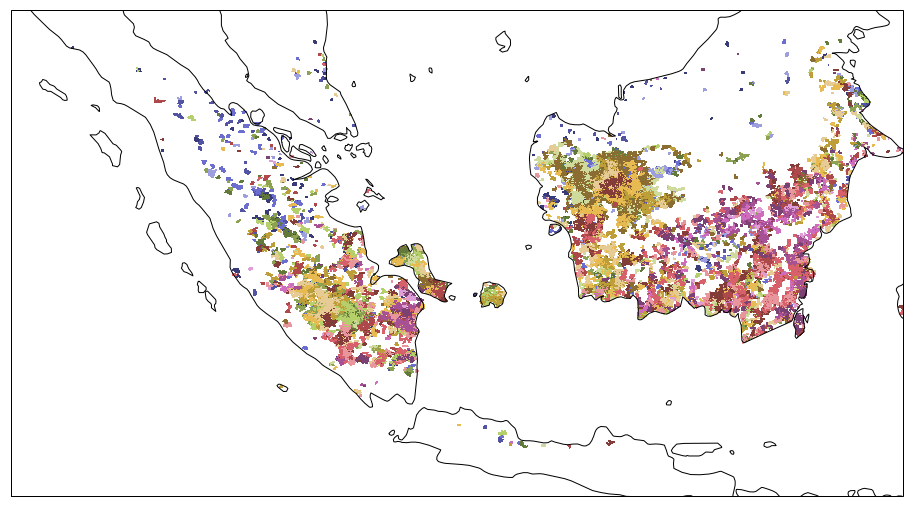

In [15]:
plt.close('all')
fig = plt.figure(figsize=(16, 12))

lat_subset = geostationary_lats[2500:3200, 600:1600]
lon_subset = geostationary_lons[2500:3200, 600:1600]
to_plot = plt_array[2500:3200, 600:1600]
to_plot = np.ma.masked_array(to_plot,  to_plot==0)

img_extent = (lon_subset[0,0], 
              lon_subset[-1,-1], 
              lat_subset[-1,-1], 
              lat_subset[0,0])

ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent(img_extent, crs=ccrs.PlateCarree())

# set a margin around the data
# ax.set_xmargin(0.05)
# ax.set_ymargin(0.10)

# add the image. Because this image was a tif, the "origin" of the image is in the
# upper left corner
#ax.imshow(plt_array[2500:3200, 600:1600], origin='upper', extent=img_extent, transform=ccrs.PlateCarree())
ax.coastlines(resolution='50m', color='black', linewidth=1)

ax.pcolormesh(lon_subset, lat_subset, to_plot, cmap='tab20b')

# # mark a known place to help us geo-locate ourselves
# ax.plot(-117.1625, 32.715, 'bo', markersize=7, transform=ccrs.Geodetic())
# ax.text(-117, 33, 'San Diego', transform=ccrs.Geodetic())

plt.show()

In [ ]:
plt.close('all')
anim = animate_timeseries(subset_fires_df)
#anim.save('animation.gif', writer='imagemagick', fps=60)
HTML(anim.to_html5_video())

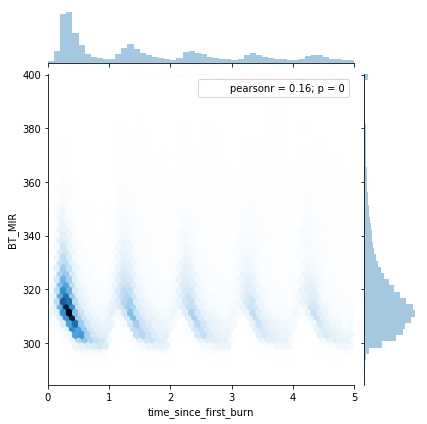

In [123]:
plt.close('all')
df_with_burn_times = subset_fires_df.copy()
df_with_burn_times['min_time'] = df_with_burn_times.obs_time.copy()
df_with_burn_times = df_with_burn_times.groupby(['ABS_line', 'ABS_samp'],as_index=False).agg({'min_time': np.min})

# standardise the start time
df_with_burn_times.min_time = df_with_burn_times.min_time.dt.normalize() 

# merge first time burn onto sub df
df_with_burn_times = pd.merge(subset_fires_df, df_with_burn_times, on=['ABS_line', 'ABS_samp'])

# get time since first burn in days
df_with_burn_times['time_since_first_burn'] = (df_with_burn_times.obs_time - df_with_burn_times.min_time) / np.timedelta64(1, 'm') / 1440.



df_with_burn_times = df_with_burn_times[(df_with_burn_times.time_since_first_burn > 0) &
                                        (df_with_burn_times.time_since_first_burn < 5)]

sns.jointplot(x="time_since_first_burn", y="BT_MIR", data=df_with_burn_times, kind='hex', )
plt.show()

# Utils:

In [5]:
def assign_peat(peat_df, fire_df):
    
    peat_lat_lon = np.dstack([np.deg2rad(peat_df.lats.values), 
                              np.deg2rad(peat_df.lons.values)])[0]
    peat_balltree = BallTree(peat_lat_lon, metric='haversine')

    # get the unique flare lats and lons for assessment in kdtree
    fire_locations = np.array(zip(np.deg2rad(fire_df.LATITUDE.values), 
                                   np.deg2rad(fire_df.LONGITUDE.values)))

    # compare the flare locations to the potential locations in the orbit
    distances, indexes = peat_balltree.query(fire_locations, k=1) 
    
    # set up the dataframe to hold the distances
    fire_df['is_peat'] = peat_df.is_peat.values[indexes]
    return fire_df

In [6]:
# Animation function

plt.close('all')
my_cmap = plt.get_cmap('tab20b')

def animate_timeseries(df, interval=25):  
    
    vmin = df.fire_id.values.min()
    vmax = df.fire_id.values.max()
    
    # set up the lats and the lons
    lat_subset = geostationary_lats[2500:3200, 600:1600]
    lon_subset = geostationary_lons[2500:3200, 600:1600]
     
    # generat the array to plot
    to_plot = np.zeros([5500, 5500]) 
    
    # list to hold data
    lines_list = [] 
    samples_list = []
    date_list = []
    id_list = []
    
    unique_times = df.obs_time.unique()
    unique_times.sort()
    for i, t in enumerate(unique_times):
        
#         if i < 0:
#             continue
        
        t_df = df[(df.obs_time == t)]
        lines_list.append(t_df.ABS_line.values.astype(int))
        samples_list.append(t_df.ABS_samp.values.astype(int))
        date_list.append(t)
        id_list.append(t_df.fire_id.values)
        
#         if i == 600:
#             break

    # Create new Figure and an Axes which fills it.
    fig = plt.figure(figsize=(14, 10))
    ax = plt.axes(projection=ccrs.PlateCarree())
    ax.coastlines(resolution='50m', color='black', linewidth=1)

    # Build the array to plot
    to_plot[lines_list[0], samples_list[0]] = id_list[0]
    to_plot = np.ma.masked_array(to_plot,  to_plot==0)

    # plot it with pcolormesh and add in the date
    z = to_plot[2500:3200, 600:1600]
    z = z[:-1, :-1]
    quad = ax.pcolormesh(lon_subset, lat_subset, z, vmin=vmin, vmax=vmax, cmap=my_cmap)
    date_text = ax.text(0.05, 0.05, '', transform=ax.transAxes)

    def update(i):
         
        # Update the quadmesh
        to_plot[lines_list[i], samples_list[i]] = id_list[i]
        z = to_plot[2500:3200, 600:1600]
        z = z[:-1, :-1]
        rav_z = z.ravel()
        quad.set_array(rav_z)
        new_color = my_cmap(rav_z)
        quad.update({'facecolors':new_color})
        date_text.set_text("Date = {}".format(date_list[i]))

    # # Construct the animation, using the update function as the animation
    # # director.
    anim = animation.FuncAnimation(fig, update, frames=len(lines_list), interval=interval)
    return anim

In [7]:
def geo_read(f, verbose=False):
    """
    read in the static data like view angle, landcover
    put them in a data dictionary
    """
    dim = 5500  # hard coded for Himawari8 possible it is 5500 in which case we need to zoom
    if verbose:
        print 'reading file %s' % f
    dtype = np.float32
    shape = (2, dim, dim)
    data = np.fromfile(f, dtype=dtype).reshape(shape)
    lat = data[0, :, :].astype(dtype)
    lon = data[1, :, :].astype(dtype)
    return lat, lon

In [8]:
def read_nc(f):
    nc_file = Dataset(f)

    # get geo
    lon_dims = nc_file['x_range'][:]
    lat_dims = nc_file['y_range'][:]
    spacing = nc_file['spacing'][:]
    lons = np.arange(lon_dims[0], lon_dims[1], spacing[0])
    lats = np.flipud(np.arange(lat_dims[0], lat_dims[1], spacing[1]))
    lons, lats = np.meshgrid(lons, lats)

    # get mask
    z = nc_file['z'][:].reshape([3000, 3000])
    mask = z > 0
    return {"is_peat": mask.ravel(), "lats": lats.ravel(), "lons": lons.ravel()}

In [ ]:
def build_frp_df(path):
    '''

    :param path: path to the frp csv files and dataframe
    :return: dataframe holding frp
    '''
    frp_csv_files = glob.glob(path + '*.csv')
    df_from_each_file = (pd.read_csv(f) for f in frp_csv_files)
    frp_df = pd.concat(df_from_each_file, ignore_index=True)

    # keep only columns on interest
    frp_df = frp_df[['FIRE_CONFIDENCE', 'ABS_line', 'ABS_samp', 'BT_MIR', 'BT_TIR',
                     'FRP_0', 'LATITUDE', 'LONGITUDE', 'year', 'month', 'day', 'time']]

    # reindex onto date
    for k in ['year', 'month', 'day', 'time']:
        frp_df[k] = frp_df[k].astype(int).astype(str)
        if k == 'time':
            frp_df[k] = frp_df[k].str.zfill(4)
        if k in ['month', 'day']:
            frp_df[k] = frp_df[k].str.zfill(2)

    format = '%Y%m%d%H%M'
    frp_df['obs_time'] = pd.to_datetime(frp_df['year'] +
                                        frp_df['month'] +
                                        frp_df['day'] +
                                        frp_df['time'], format=format)
    frp_df['obs_date'] = frp_df['obs_time'].dt.date

    # drop columns we dont needs
    #frp_df.drop(['LONGITUDE', 'LATITUDE'], axis=1, inplace=True)
    frp_df.drop(['year', 'month', 'day', 'time'], axis=1, inplace=True)

    frp_df.to_pickle(path + 'frp_df.p')
    
build_frp_df('/Users/danielfisher/Projects/kcl-fire-aot/data/Asia/processed/himawari/updated/')